<img src="../Pnuemonia_Classifier/KyleDevLogo.jpg" alt="Kyles Logo" style="width: 1000px; border-radius: 2%; margin: auto; display: block;" />

# **Alzheimers Demented Classification**
By: Kyle Hostetter

## Data Information

This was a dataset that was gathered from Kaggle.com that contains 6,400 images of 4 major classes of alzheimers. The classes are non, very mild, mild, and moderate demented. The goal is to create a CNN model that will classify each of these stages with the highest accuracy possible!

**Data**
* Non Demented
* Very Mild Demented
* Mild Demented
* Moderate Demented

In [1]:
# Import Base Libraries
import os 
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_curve

import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras.models import load_model
from keras.preprocessing import image

BASE_DIR = 'Dataset/'
BATCH_SIZE = 64
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_SIZE = (128,128)

# Change TensorFlow settings
# os.environ['TF_SPP_MIN_LOG_LEVEL'] = '2'                            # Change the logging output level to 2
physical_devices = tf.config.list_physical_devices('GPU')           # Configure the GPU as the device for computations

# Print out TensorFlow Version
print(tf.__version__)
print(physical_devices)



2024-05-09 16:47:43.829015: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 16:47:43.912079: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 16:47:45.113697: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 16:47:47.545681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 16:47:55.762238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

2.16.1
[]


In [2]:
# Create Training and testing DataFrames
train_df, test_df = tf.keras.preprocessing.image_dataset_from_directory(directory=BASE_DIR,
                                                                        color_mode='grayscale',
                                                                        label_mode='int',
                                                                        batch_size=BATCH_SIZE,
                                                                        image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                                        validation_split=.2,
                                                                        subset='both',
                                                                        shuffle=True,
                                                                        seed=0)

print('\n'+50*'-')
# Non Demented Images
non_images = glob(BASE_DIR + 'Non_Demented/*.jpg')
print('Amount of Non Demented Images:',len(non_images))

# Very Mild Demented Images
very_mild_images = glob(BASE_DIR + '/Very_Mild_Demented/*.jpg')
print('Amount of Very Mild Demented Images:',len(very_mild_images))

# Mild Demented Images
mild_images = glob(BASE_DIR + '/Mild_Demented/*.jpg')
print('Amount of Mild Demented Images:',len(mild_images))

# Moderate Demented Images
moderate_images = glob(BASE_DIR + '/Moderate_Demented/*.jpg')
print('Amount of Moderate Demented Images:',len(moderate_images))

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Using 1280 files for validation.

--------------------------------------------------
Amount of Non Demented Images: 3200
Amount of Very Mild Demented Images: 2240
Amount of Mild Demented Images: 896
Amount of Moderate Demented Images: 64


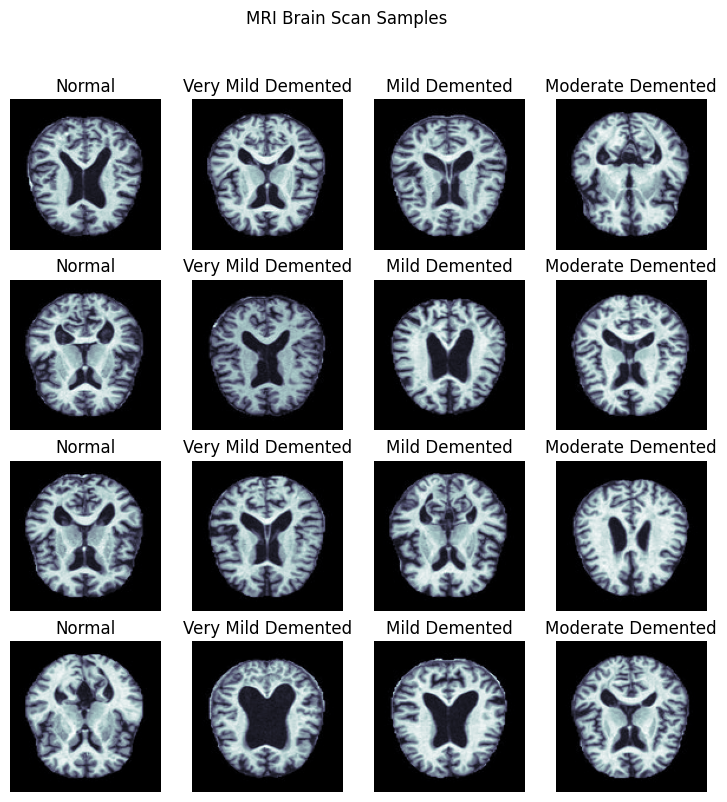

In [37]:

# Figure Variables
rows = 4
colorMap = 'bone'

# Set Figure Size
plt.figure(figsize=(9,9))
plt.suptitle('MRI Brain Scan Samples')

# Add Counter
j=1

# Plot image for normal lungs
for i in range(rows):

    # Build Image & store in variable
    non_image = np.asarray(plt.imread(non_images[i]))
    very_mild_image = np.asarray(plt.imread(very_mild_images[i]))
    mild_image = np.asarray(plt.imread(mild_images[i]))
    moderate_image = np.asarray(plt.imread(moderate_images[i]))

    plt.subplot(rows, 4, j)
    plt.imshow(non_image, cmap=colorMap)
    plt.title("Normal")
    plt.axis('off')
    j = j+1
    
    plt.subplot(rows,4,j)
    plt.imshow(very_mild_image, cmap=colorMap)
    plt.title('Very Mild Demented')
    plt.axis('off')
    j = j+1

    plt.subplot(rows,4,j)
    plt.imshow(mild_image, cmap= colorMap)
    plt.title('Mild Demented')
    plt.axis('off')
    j = j+1

    plt.subplot(rows,4,j)
    plt.imshow(moderate_image, cmap=colorMap)
    plt.title('Moderate Demented')
    plt.axis('off')
    j = j+1

In [19]:
# Input Variables
EPOCHS = 15

# Input matric that uses 2x2 pixels.
MATRIX = (2,2)

# Build Convolution Neural Network
model = keras.Sequential(name='Alzheimers_CNN', layers=
    [
        keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1), name='Input_Layer'),
        layers.Rescaling(1./255, name='Res_Layer1'),
        
        layers.Conv2D(32, MATRIX, padding='same', activation='relu', name='Conv_Layer1'),
        layers.MaxPooling2D(name='Max_Pooling1'),

        layers.Conv2D(32, MATRIX, padding='same', activation='relu', name='Conv_Layer2'),
        layers.MaxPooling2D(name='Max_Pooling2'),

        # layers.Conv2D(32, MATRIX, padding='same', activation='relu', name='Conv_Layer3'),
        # layers.MaxPooling2D(name='Max_Pooling3'),
        
        layers.Flatten(name='Flatten_Layer'),
        layers.Dense(64, activation='relu', name='Dense_layer'),
        layers.Dense(4, activation='softmax', name='Final_Output')
    ]
)

# Print Out Model Architecture
print(model.summary())

# Run & Compile Deep Learning Model
model.compile(optimizer='adam',                         # Use the Adam optimizer
              loss='sparse_categorical_crossentropy',   # Use sparse crossentropy since there are more than 2 classes
              metrics=['accuracy'])                     # Optimize Accuracy of model

# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Create a Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',   # Metric to watch during training 
                                            patience=1)           # Continue training 3 epocks past a decrease in the monitor feature

# Train model
history=model.fit(train_df,                  # Data to train on       
                  validation_data=test_df,   # Validation Data
                  epochs=EPOCHS,             # Number of Epochs 
                  batch_size=BATCH_SIZE,     # Number of samples to train in SGD at a time
                  callbacks=[callback])      # Stop early if there is no increase in model metrics

# Evaluate Model
test_loss, test_score = model.evaluate(test_df,                # What data to evaluate model on          
                                       batch_size=BATCH_SIZE)   # Number of samples to train in SGD at a time

# # Delete Old Model & Save New Keras Model
os.remove('Alzheimers_CNN_Model.h5')
model.save("Alzheimers_CNN_Model.h5")

# Print out Final results
print(f'''\n

        Final Model Results
----------------------------------
Accuracy: {round(test_score * 100,1)}%
Loss: {test_loss}
''')

Model: "Alzheimers_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Res_Layer1 (Rescaling)          │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Layer1 (Conv2D)            │ (None, 128, 128, 32)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling1 (MaxPooling2D)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Layer2 (Conv2D)            │ (None, 64, 64, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling2 (MaxPooling2D)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_layer (Dense)             │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Final_Output (Dense)            │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,101,764 (8.02 MB)

 Trainable params: 2,101,764 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15


80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.4579 - loss: 1.0481 - val_accuracy: 0.5758 - val_loss: 0.9228
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - accuracy: 0.5974 - loss: 0.8711 - val_accuracy: 0.6703 - val_loss: 0.7544
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.7099 - loss: 0.6884 - val_accuracy: 0.7672 - val_loss: 0.5955
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.8123 - loss: 0.5001 - val_accuracy: 0.7281 - val_loss: 0.5641
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - accuracy: 0.8815 - loss: 0.3418 - val_accuracy: 0.8555 - val_loss: 0.3672
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 0.9319 - loss: 0.2214 - val_accuracy: 0.8922 - val_loss: 0.2913
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 28s 319ms/step - accuracy: 0.9666 - loss: 0.1297 - val_accuracy: 0.9219 - val_loss: 0.2214
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - accuracy: 0.9849 - loss: 0.0814 - val_accuracy: 0.922




        Final Model Results
----------------------------------
Accuracy: 95.8%
Loss: 0.11338142305612564



In [24]:
model.save("Alzheimers_CNN_Model.h5")
model.save("Alzheimers_CNN_Model.keras")

In [23]:
y_pred = model.predict(test_df)
print(test_df.class_names)
print(y_pred[2])

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 373ms/step
['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
[1.6262662e-04 2.7468520e-06 9.9969828e-01 1.3630830e-04]


In [22]:
sum(y_pred[2])

0.9999999630560978

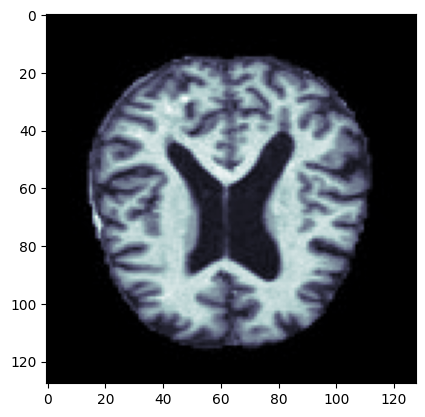

In [36]:
test_image = np.asarray(plt.imread(non_images[0]))

plt.imshow(test_image, cmap='bone')

fixed_image = np.expand_dims(test_image,axis=0)

In [32]:
test = model.predict(fixed_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [35]:
print(train_df.class_names)
print(test)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
[[2.0836464e-04 5.0600634e-06 9.8984212e-01 9.9444101e-03]]


In [57]:
def predictImage(model,image):
    # Class Name Labels
    labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

    # Expand image into readalbe image array
    fixed_image = np.expand_dims(image,axis=0)

    # Apply prediciton model
    pred_image = model.predict(fixed_image)

    # Index of highest probability image
    index_max = np.argmax(pred_image)

    # Attach Class Label
    pred = labels[index_max]
    proba = round(pred_image[0][index_max] * 100,2)

    # Return Highest probable label
    return proba, pred

proba, pred = predictImage(model=model, image=test_image)

print(pred,':',proba)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Non Demented : 98.98


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


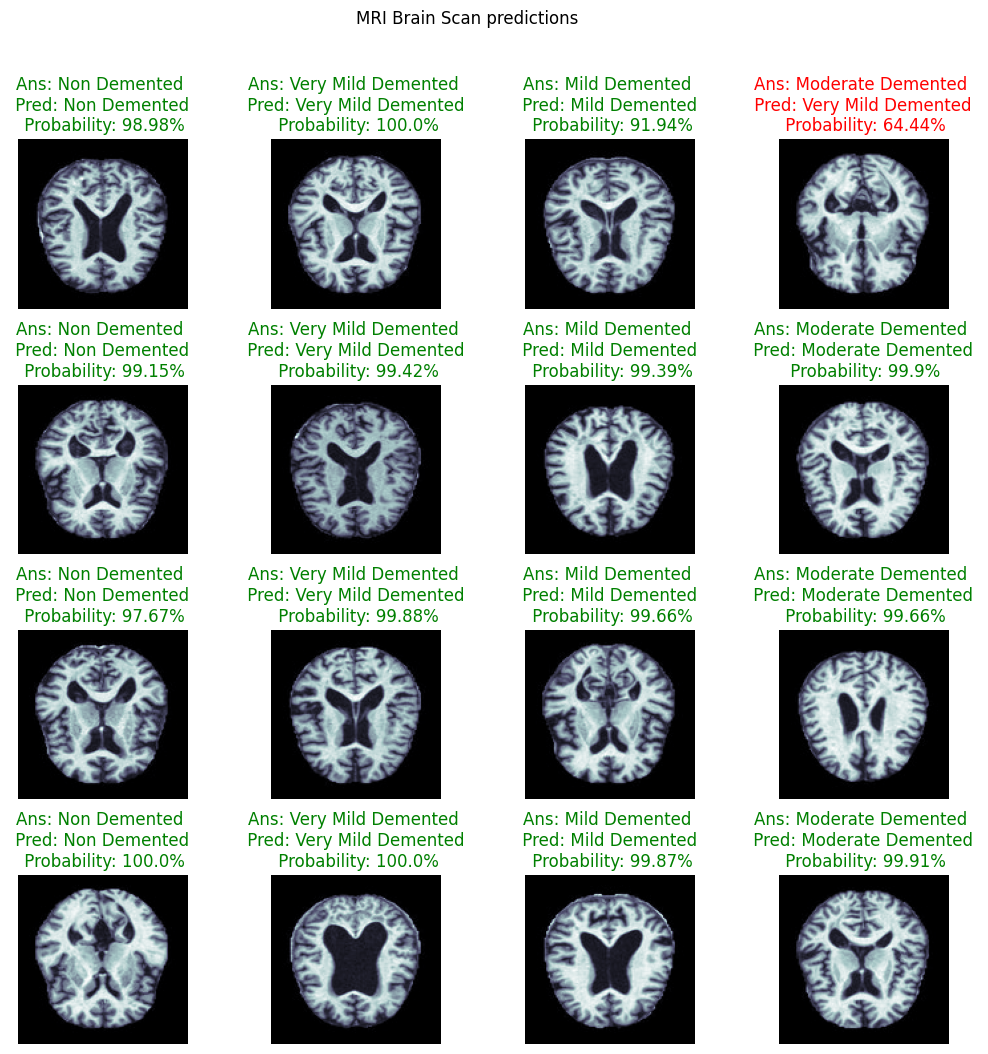

In [81]:
# Figure Variables
rows = 4
colorMap = 'bone'

# Set Figure Size
plt.figure(figsize=(12,12))
plt.suptitle('MRI Brain Scan Predictions')

# Add Counter
j=1

# Plot image for normal lungs
for i in range(rows):

    plt.subplots_adjust(hspace=0.3,wspace=0.5)

    # Build Image & store in variable
    non_image = np.asarray(plt.imread(non_images[i]))
    proba1, pred1 = predictImage(model=model, image=non_image)

    very_mild_image = np.asarray(plt.imread(very_mild_images[i]))
    proba2, pred2 = predictImage(model=model, image=very_mild_image)

    mild_image = np.asarray(plt.imread(mild_images[i]))
    proba3, pred3 = predictImage(model=model, image=mild_image)

    moderate_image = np.asarray(plt.imread(moderate_images[i]))
    proba4, pred4 = predictImage(model=model, image=moderate_image)

    if pred1 == 'Non Demented':
        pred1_color = 'green'
    else:
        pred1_color = 'red'

    if pred2 == 'Very Mild Demented':
        pred2_color = 'green'
    else:
        pred2_color = 'red'

    if pred3 == 'Mild Demented':
        pred3_color = 'green'
    else:
        pred3_color = 'red'

    if pred4 == 'Moderate Demented':
        pred4_color = 'green'
    else:
        pred4_color = 'red'

    plt.subplot(rows, 4, j)
    plt.imshow(non_image, cmap=colorMap)
    plt.title(f'''Ans: Non Demented \n Pred: {pred1} \n Probability: {proba1}%''', color=pred1_color)
    plt.axis('off')
    j = j+1
    
    plt.subplot(rows,4,j)
    plt.imshow(very_mild_image, cmap=colorMap)
    plt.title(f'''Ans: Very Mild Demented \n Pred: {pred2} \n Probability: {proba2}%''', color=pred2_color)
    plt.axis('off')
    j = j+1

    plt.subplot(rows,4,j)
    plt.imshow(mild_image, cmap= colorMap)
    plt.title(f'''Ans: Mild Demented \n Pred: {pred3} \n Probability: {proba3}%''', color=pred3_color)
    plt.axis('off')
    j = j+1

    plt.subplot(rows,4,j)
    plt.imshow(moderate_image, cmap=colorMap)
    plt.title(f'''Ans: Moderate Demented \n Pred: {pred4} \n Probability: {proba4}%''', color=pred4_color)
    plt.axis('off')
    j = j+1